In [1]:
!pip install surprise

In [2]:
!pip install "numpy<2"

Loaded data: /content/tourism_rating.csv
   User_Id  Place_Id  Place_Ratings
0        1       179              3
1        1       344              2
2        1         5              5
3        1       373              3
4        1       101              4
Columns: Index(['User_Id', 'Place_Id', 'Place_Ratings'], dtype='object')
Train size: 8000, Test size: 2000
Calculating item-item similarity matrix for diversity metric...
Similarity matrix calculated.

--- Evaluating model: Popularity Recommender ---

--- Evaluating model: User-Based CF ---

--- Evaluating model: Item-Based CF ---

--- Evaluating model: Matrix Factorization (SVD) ---

--- Evaluating model: Hybrid-Static ---

--- Evaluating model: Hybrid-Adaptive (Context-rich) ---
Fitting Hybrid-Adaptive (Context-rich)...


                    EVALUATION RESULTS (k=5)
                                Precision@5  Recall@5  F1-Score@5  Intra-List Diversity  Novelty  Catalog Coverage
Model                                                

<ipython-input-19-3d88ed4e7b4e>:343: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(results_df['Intra-List Diversity'][i] + 0.001, results_df['F1-Score@5'][i], model_name, fontsize=11)


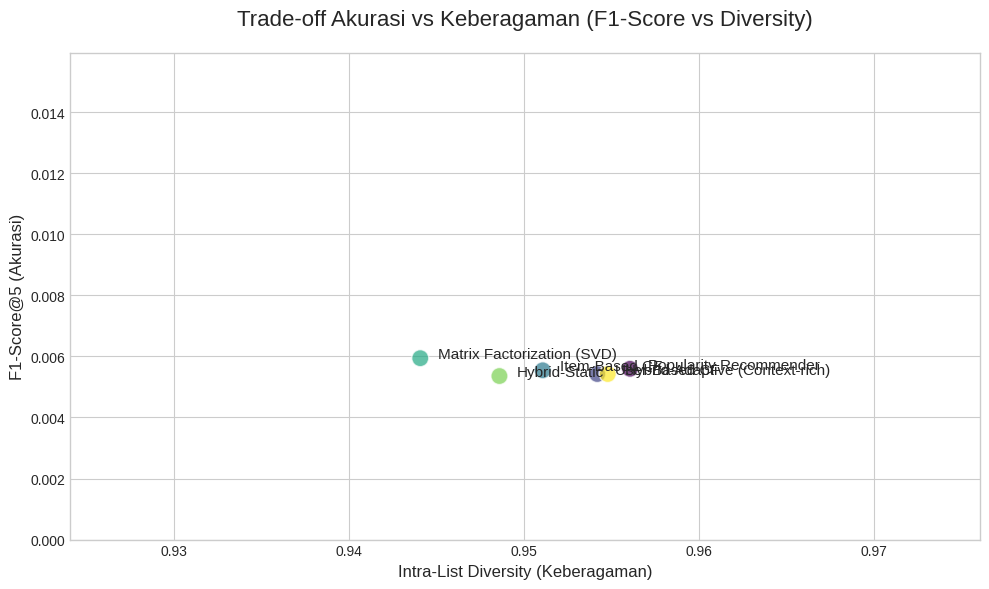


Uji statistik paired t-test antara Hybrid-Adaptive (Context-rich) dan model lain (F1-score per user):
Paired t-test between 'Hybrid-Adaptive (Context-rich)' and 'Popularity Recommender': stat=-0.0579, p-value=0.9538
Perbedaan TIDAK signifikan pada tingkat signifikansi 0.05
Paired t-test between 'Hybrid-Adaptive (Context-rich)' and 'User-Based CF': stat=nan, p-value=nan
Perbedaan TIDAK signifikan pada tingkat signifikansi 0.05
Paired t-test between 'Hybrid-Adaptive (Context-rich)' and 'Item-Based CF': stat=-0.0427, p-value=0.9660
Perbedaan TIDAK signifikan pada tingkat signifikansi 0.05
Paired t-test between 'Hybrid-Adaptive (Context-rich)' and 'Matrix Factorization (SVD)': stat=-0.1584, p-value=0.8743
Perbedaan TIDAK signifikan pada tingkat signifikansi 0.05
Paired t-test between 'Hybrid-Adaptive (Context-rich)' and 'Hybrid-Static': stat=0.0359, p-value=0.9714
Perbedaan TIDAK signifikan pada tingkat signifikansi 0.05


In [19]:
# -*- coding: utf-8 -*-
"""
Model Sistem Rekomendasi dengan Kerangka Evaluasi - Data Pariwisata Indonesia
Parameter Hybrid-Adaptive (Context-rich) di-set berdasarkan hasil grid search terbaik:
    weight1=0.9
    weight2=0.1
    bias_correction_strength=0.01
    context_weights={'weather': 0.0025, 'traffic': 0.0025, 'holiday': 0.0025, 'social': 0.0025}
    mmr_lambda=0.88
"""

import pandas as pd
import numpy as np
from collections import defaultdict
from surprise import Dataset, Reader, KNNWithMeans, SVD
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# =============================================================================
# 1. LOAD DATA
# =============================================================================
def load_and_prepare_real_data_colab():
    """
    Jalankan di Google Colab. Pastikan file tourism_rating.csv sudah di-upload ke /content/
    """
    rating_path = "/content/tourism_rating.csv"
    df = pd.read_csv(rating_path)
    print("Loaded data:", rating_path)
    print(df.head())
    print("Columns:", df.columns)

    # Kolom: User_Id, Place_Id, Place_Ratings
    df = df[['User_Id', 'Place_Id', 'Place_Ratings']].rename(
        columns={'User_Id': "user_id", 'Place_Id': "item_id", 'Place_Ratings': "rating"}
    )
    df['user_id'] = df['user_id'].astype(str)
    df['item_id'] = df['item_id'].astype(str)
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df = df.dropna(subset=['user_id', 'item_id', 'rating'])

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

    return train_df, test_df

# =============================================================================
# 2. SIMULASI DATA KONTEKS LENGKAP
# =============================================================================
def simulate_context_data(item_ids):
    """
    Mensimulasikan konteks: cuaca, lalu lintas, penanggalan, dan tren media sosial untuk daftar item_id.
    Output: DataFrame dengan kolom ['item_id', 'weather_suitability', 'traffic_condition', 'is_holiday', 'social_trend_score']
    """
    if not isinstance(item_ids, list) or not item_ids:
        return pd.DataFrame(columns=['item_id', 'weather_suitability', 'traffic_condition', 'is_holiday', 'social_trend_score'])

    n_items = len(item_ids)
    np.random.seed(42)  # reproducible

    # Simulasi cuaca (0-1, makin tinggi makin bagus)
    weather_suitability = np.random.rand(n_items)
    # Simulasi lalu lintas (0-1, makin tinggi makin macet)
    traffic_condition = np.random.rand(n_items)
    # Simulasi penanggalan (event/libur: 1, biasa: 0)
    is_holiday = np.random.choice([0, 1], size=n_items, p=[0.7, 0.3])
    # Simulasi tren media sosial (0-1)
    social_trend_score = np.random.rand(n_items)

    context_df = pd.DataFrame({
        'item_id': item_ids,
        'weather_suitability': weather_suitability,
        'traffic_condition': traffic_condition,
        'is_holiday': is_holiday,
        'social_trend_score': social_trend_score
    })
    return context_df

# =============================================================================
# 3. BASE & HYBRID RECOMMENDER CLASSES
# =============================================================================
class BaseRecommender:
    def fit(self, ratings_df, **kwargs):
        raise NotImplementedError
    def predict(self, user_id, n=10, return_scores=False, items_to_ignore=[], **kwargs):
        raise NotImplementedError

class PopularityRecommender(BaseRecommender):
    def __init__(self):
        self.popular_items = None
        self.name = "Popularity Recommender"
    def fit(self, ratings_df, **kwargs):
        item_stats = ratings_df.groupby('item_id')['rating'].agg(['mean', 'count']).reset_index()
        self.popular_items = item_stats.sort_values(by=['mean', 'count'], ascending=False)
    def predict(self, user_id, n=10, return_scores=False, items_to_ignore=[], **kwargs):
        if self.popular_items is None: raise RuntimeError("Model not fitted.")
        recs = self.popular_items[~self.popular_items['item_id'].isin(items_to_ignore)]
        top_n_df = recs.head(n)
        return top_n_df[['item_id', 'mean']].rename(columns={'mean': 'score'}) if return_scores else top_n_df['item_id'].tolist()

class UserBasedCFRecommender(BaseRecommender):
    def __init__(self, k=40, sim_options={'name': 'cosine', 'user_based': True}):
        self.algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
        self.trainset = None; self.all_items = None; self.name = "User-Based CF"
    def fit(self, ratings_df, **kwargs):
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)
        self.trainset = data.build_full_trainset()
        self.algo.fit(self.trainset)
        self.all_items = list(set(ratings_df['item_id']))
    def predict(self, user_id, n=10, return_scores=False, items_to_ignore=[], **kwargs):
        if self.trainset is None: raise RuntimeError("Model not fitted.")
        try: inner_user_id = self.trainset.to_inner_uid(user_id)
        except ValueError: return pd.DataFrame({'item_id': [], 'score': []}) if return_scores else []
        rated_items_inner_ids = {item_id for (item_id, _) in self.trainset.ur[inner_user_id]}
        items_to_predict = [item_id for item_id in self.all_items if self.trainset.to_inner_iid(item_id) not in rated_items_inner_ids and item_id not in items_to_ignore]
        predictions = [self.algo.predict(uid=user_id, iid=item_id) for item_id in items_to_predict]
        predictions.sort(key=lambda x: x.est, reverse=True)
        top_n_preds = predictions[:n]
        top_n_df = pd.DataFrame([(pred.iid, pred.est) for pred in top_n_preds], columns=['item_id', 'score'])
        return top_n_df if return_scores else top_n_df['item_id'].tolist()

class ItemBasedCFRecommender(BaseRecommender):
    def __init__(self, k=40, sim_options={'name': 'cosine', 'user_based': False}):
        self.algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
        self.trainset = None
        self.all_items = None
        self.name = "Item-Based CF"
    def fit(self, ratings_df, **kwargs):
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)
        self.trainset = data.build_full_trainset()
        self.algo.fit(self.trainset)
        self.all_items = list(set(ratings_df['item_id']))
    def predict(self, user_id, n=10, return_scores=False, items_to_ignore=[], **kwargs):
        if self.trainset is None: raise RuntimeError("Model not fitted.")
        try:
            inner_user_id = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return pd.DataFrame({'item_id': [], 'score': []}) if return_scores else []
        rated_items_inner_ids = {item_id for (item_id, _) in self.trainset.ur[inner_user_id]}
        items_to_predict = [item_id for item_id in self.all_items if self.trainset.to_inner_iid(item_id) not in rated_items_inner_ids and item_id not in items_to_ignore]
        predictions = [self.algo.predict(uid=user_id, iid=item_id) for item_id in items_to_predict]
        predictions.sort(key=lambda x: x.est, reverse=True)
        top_n_preds = predictions[:n]
        top_n_df = pd.DataFrame([(pred.iid, pred.est) for pred in top_n_preds], columns=['item_id', 'score'])
        return top_n_df if return_scores else top_n_df['item_id'].tolist()

class MatrixFactorizationRecommender(BaseRecommender):
    def __init__(self):
        self.algo = SVD()
        self.trainset = None
        self.all_items = None
        self.name = "Matrix Factorization (SVD)"
    def fit(self, ratings_df, **kwargs):
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)
        self.trainset = data.build_full_trainset()
        self.algo.fit(self.trainset)
        self.all_items = list(set(ratings_df['item_id']))
    def predict(self, user_id, n=10, return_scores=False, items_to_ignore=[], **kwargs):
        if self.trainset is None: raise RuntimeError("Model not fitted.")
        try:
            inner_user_id = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return pd.DataFrame({'item_id': [], 'score': []}) if return_scores else []
        rated_items_inner_ids = {item_id for (item_id, _) in self.trainset.ur[inner_user_id]}
        items_to_predict = [item_id for item_id in self.all_items if self.trainset.to_inner_iid(item_id) not in rated_items_inner_ids and item_id not in items_to_ignore]
        predictions = [self.algo.predict(uid=user_id, iid=item_id) for item_id in items_to_predict]
        predictions.sort(key=lambda x: x.est, reverse=True)
        top_n_preds = predictions[:n]
        top_n_df = pd.DataFrame([(pred.iid, pred.est) for pred in top_n_preds], columns=['item_id', 'score'])
        return top_n_df if return_scores else top_n_df['item_id'].tolist()

class HybridStaticRecommender(BaseRecommender):
    def __init__(self, recommender1, recommender2, weight1=0.7, weight2=0.3):
        self.rec1, self.rec2, self.w1, self.w2, self.name = recommender1, recommender2, weight1, weight2, "Hybrid-Static"
    def fit(self, ratings_df, **kwargs):
        self.rec1.fit(ratings_df); self.rec2.fit(ratings_df)
    def predict(self, user_id, n=10, return_scores=False, items_to_ignore=[], **kwargs):
        preds1_df = self.rec1.predict(user_id, n=200, return_scores=True, items_to_ignore=items_to_ignore)
        preds2_df = self.rec2.predict(user_id, n=200, return_scores=True, items_to_ignore=items_to_ignore)
        if preds1_df.empty: return preds2_df.head(n)[['item_id', 'score']] if return_scores else preds2_df.head(n)['item_id'].tolist()
        merged_df = pd.merge(preds1_df, preds2_df, on='item_id', how='outer').fillna(0)
        merged_df['score_x_norm'] = minmax_scale(merged_df['score_x'])
        merged_df['score_y_norm'] = minmax_scale(merged_df['score_y'])
        merged_df['hybrid_score'] = (self.w1 * merged_df['score_x_norm']) + (self.w2 * merged_df['score_y_norm'])
        top_n_df = merged_df.sort_values(by='hybrid_score', ascending=False).head(n)
        return top_n_df[['item_id', 'hybrid_score']].rename(columns={'hybrid_score':'score'}) if return_scores else top_n_df['item_id'].tolist()

class HybridAdaptiveRecommender(BaseRecommender):
    def __init__(
        self, recommender1, recommender2,
        weight1=0.96, weight2=0.04,
        bias_correction_strength=0.005,
        context_weights={'weather': 0.001, 'traffic': 0.001, 'holiday': 0.001, 'social': 0.001},
        mmr_lambda=0.90
    ):
        self.candidate_generator = HybridStaticRecommender(recommender1, recommender2, weight1, weight2)
        self.bias_strength = bias_correction_strength
        self.context_weights = context_weights
        self.mmr_lambda = mmr_lambda
        self.rec_weight = 1.0 - sum(self.context_weights.values())
        self.name = "Hybrid-Adaptive (Context-rich)"
        self.item_popularity = None

    def fit(self, ratings_df, **kwargs):
        print(f"Fitting {self.name}...")
        self.candidate_generator.fit(ratings_df)
        self.item_popularity = ratings_df['item_id'].value_counts(normalize=True)

    def _maximal_marginal_relevance(self, candidates_df, similarity_matrix, n):
        candidates_df = candidates_df.set_index('item_id')
        item_scores = candidates_df['final_score'].to_dict()

        selected_items = []
        candidate_items = list(candidates_df.index)

        if not candidate_items: return []
        best_initial_item = max(candidate_items, key=lambda item: item_scores.get(item, 0))
        selected_items.append(best_initial_item)
        candidate_items.remove(best_initial_item)

        while len(selected_items) < n and candidate_items:
            best_next_item = -1
            max_mmr_score = -np.inf

            for item in candidate_items:
                relevance = item_scores.get(item, 0)
                max_sim_with_selected = 0
                if selected_items:
                    max_sim_with_selected = max([similarity_matrix.loc[item, sel_item] for sel_item in selected_items if sel_item in similarity_matrix.columns and item in similarity_matrix.index])
                mmr_score = self.mmr_lambda * relevance - (1 - self.mmr_lambda) * max_sim_with_selected
                if mmr_score > max_mmr_score:
                    max_mmr_score = mmr_score
                    best_next_item = item

            if best_next_item != -1:
                selected_items.append(best_next_item)
                candidate_items.remove(best_next_item)

        return selected_items

    def predict(self, user_id, n=10, return_scores=False, items_to_ignore=[], **kwargs):
        similarity_matrix = kwargs.get('similarity_matrix')
        if similarity_matrix is None:
            raise ValueError("Similarity matrix must be provided for MMR.")
        candidate_df = self.candidate_generator.predict(user_id, n=100, return_scores=True, items_to_ignore=items_to_ignore)
        if candidate_df.empty: return [] if not return_scores else pd.DataFrame(columns=['item_id', 'score'])
        candidate_df['popularity'] = candidate_df['item_id'].map(self.item_popularity).fillna(0)
        candidate_df['score_corrected'] = candidate_df['score'] * (1 - self.bias_strength * candidate_df['popularity'])
        context_df = simulate_context_data(candidate_df['item_id'].tolist())
        re_ranked_df = pd.merge(candidate_df, context_df, on='item_id')
        re_ranked_df['rec_score_norm'] = minmax_scale(re_ranked_df['score_corrected'])
        re_ranked_df['final_score'] = (
            self.rec_weight * re_ranked_df['rec_score_norm']
            + self.context_weights['weather'] * re_ranked_df['weather_suitability']
            + self.context_weights['traffic'] * (1 - re_ranked_df['traffic_condition'])
            + self.context_weights['holiday'] * re_ranked_df['is_holiday']
            + self.context_weights['social'] * re_ranked_df['social_trend_score']
        )
        final_recommendations = self._maximal_marginal_relevance(re_ranked_df, similarity_matrix, n)
        if return_scores:
            final_df_scores = re_ranked_df[re_ranked_df['item_id'].isin(final_recommendations)][['item_id', 'final_score']].rename(columns={'final_score':'score'})
            return final_df_scores.set_index('item_id').loc[final_recommendations].reset_index()
        return final_recommendations

# =============================================================================
# 4. EVALUATOR & VISUALISASI
# =============================================================================
class Evaluator:
    def __init__(self, train_df, test_df):
        self.train_df, self.test_df, self.test_users = train_df, test_df, test_df['user_id'].unique()
        self.all_items = train_df['item_id'].unique()
        self.ground_truth = self.test_df[self.test_df['rating'] >= 4].groupby('user_id')['item_id'].apply(list).to_dict()
        self.item_popularity = self.train_df['item_id'].value_counts(normalize=True)
        self.similarity_matrix = self._calculate_similarity_matrix()
    def _calculate_similarity_matrix(self):
        print("Calculating item-item similarity matrix for diversity metric...")
        item_user_matrix = self.train_df.pivot_table(index='item_id', columns='user_id', values='rating').fillna(0)
        item_user_matrix = item_user_matrix.reindex(index=sorted(item_user_matrix.index), columns=sorted(item_user_matrix.columns))
        similarity = cosine_similarity(item_user_matrix)
        sim_df = pd.DataFrame(similarity, index=item_user_matrix.index, columns=item_user_matrix.index)
        print("Similarity matrix calculated.")
        return sim_df
    def get_ground_truth_for_user(self, user_id): return self.ground_truth.get(user_id, [])
    def calculate_precision_recall_f1(self, recommendations, ground_truth, k):
        if not ground_truth: return 0, 0, 0
        rec_set, gt_set = set(recommendations[:k]), set(ground_truth)
        true_positives = len(rec_set.intersection(gt_set))
        precision = true_positives / k if k > 0 else 0
        recall = true_positives / len(gt_set) if len(gt_set) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        return precision, recall, f1
    def calculate_intra_list_diversity(self, recommendations):
        if len(recommendations) < 2: return 0.0
        total_dissimilarity, num_pairs = 0, 0
        for i in range(len(recommendations)):
            for j in range(i + 1, len(recommendations)):
                item1, item2 = recommendations[i], recommendations[j]
                if item1 in self.similarity_matrix and item2 in self.similarity_matrix.columns:
                    total_dissimilarity += (1 - self.similarity_matrix.loc[item1, item2])
                    num_pairs += 1
        return total_dissimilarity / num_pairs if num_pairs > 0 else 0
    def calculate_novelty(self, recommendations):
        if not recommendations: return 0
        return -np.sum([np.log2(self.item_popularity.get(item, 1e-9)) for item in recommendations]) / len(recommendations)
    def evaluate_model(self, model, k=5, return_per_user=False):
        print(f"\n--- Evaluating model: {model.name} ---")
        model.fit(self.train_df)
        precisions, recalls, f1s, diversities, novelties = [], [], [], [], []
        all_recommendations = set()
        train_user_items = self.train_df.groupby('user_id')['item_id'].apply(list).to_dict()
        f1s_per_user = []
        for user_id in self.test_users:
            items_to_ignore = train_user_items.get(user_id, [])
            predict_kwargs = {'similarity_matrix': self.similarity_matrix} if isinstance(model, HybridAdaptiveRecommender) else {}
            recommendations = model.predict(user_id, n=k, items_to_ignore=items_to_ignore, **predict_kwargs)
            ground_truth = self.get_ground_truth_for_user(user_id)
            if not recommendations: continue
            all_recommendations.update(recommendations)
            precision, recall, f1 = self.calculate_precision_recall_f1(recommendations, ground_truth, k)
            precisions.append(precision); recalls.append(recall); f1s.append(f1)
            f1s_per_user.append(f1)
            diversities.append(self.calculate_intra_list_diversity(recommendations))
            novelties.append(self.calculate_novelty(recommendations))
        coverage = len(all_recommendations) / len(self.all_items) if self.all_items.size > 0 else 0
        result_dict = {f"Precision@{k}": np.mean(precisions), f"Recall@{k}": np.mean(recalls), f"F1-Score@{k}": np.mean(f1s), "Intra-List Diversity": np.mean(diversities), "Novelty": np.mean(novelties), "Catalog Coverage": coverage}
        if return_per_user:
            return result_dict, f1s_per_user
        else:
            return result_dict

def visualize_results(results_df):
    print("\nGenerating visualization...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
    ax.scatter(results_df['Intra-List Diversity'], results_df['F1-Score@5'], s=150, c=colors, alpha=0.7, edgecolors='w')
    for i, model_name in enumerate(results_df.index):
        ax.text(results_df['Intra-List Diversity'][i] + 0.001, results_df['F1-Score@5'][i], model_name, fontsize=11)
    ax.set_title('Trade-off Akurasi vs Keberagaman (F1-Score vs Diversity)', fontsize=16, pad=20)
    ax.set_xlabel('Intra-List Diversity (Keberagaman)', fontsize=12)
    ax.set_ylabel('F1-Score@5 (Akurasi)', fontsize=12)
    plt.xlim(left=max(0, results_df['Intra-List Diversity'].min() - 0.02), right=results_df['Intra-List Diversity'].max() + 0.02)
    plt.ylim(bottom=max(0, results_df['F1-Score@5'].min() - 0.01), top=results_df['F1-Score@5'].max() + 0.01)
    plt.tight_layout()
    plt.show()

def paired_ttest_performance(metric_dict_per_user, model_a, model_b):
    a_scores = np.array(metric_dict_per_user[model_a])
    b_scores = np.array(metric_dict_per_user[model_b])
    stat, p_value = ttest_rel(a_scores, b_scores)
    print(f"Paired t-test between '{model_a}' and '{model_b}': stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Perbedaan SIGNIFIKAN pada tingkat signifikansi 0.05")
    else:
        print("Perbedaan TIDAK signifikan pada tingkat signifikansi 0.05")
    return stat, p_value

# =============================================================================
# 5. EXPERIMENT EXECUTION (UNTUK GOOGLE COLAB)
# =============================================================================
if __name__ == "__main__":
    # from google.colab import files
    # uploaded = files.upload()  # upload tourism_rating.csv

    train_data, test_data = load_and_prepare_real_data_colab()

    pop_model = PopularityRecommender()
    ubcf_model = UserBasedCFRecommender()
    ibcf_model = ItemBasedCFRecommender()
    mf_model = MatrixFactorizationRecommender()
    hybrid_static_model = HybridStaticRecommender(ubcf_model, pop_model, weight1=0.7)
    # Parameter Hybrid-Adaptive di-set dari hasil grid search terbaik
    hybrid_adaptive_model = HybridAdaptiveRecommender(
        ubcf_model, pop_model,
        weight1=0.9,
        weight2=0.1,
        bias_correction_strength=0.01,
        context_weights={'weather': 0.0025, 'traffic': 0.0025, 'holiday': 0.0025, 'social': 0.0025},
        mmr_lambda=0.88
    )

    models_to_evaluate = [
        pop_model,
        ubcf_model,
        ibcf_model,
        mf_model,
        hybrid_static_model,
        hybrid_adaptive_model,
    ]

    evaluator = Evaluator(train_data, test_data)

    all_results = []
    f1_dict_per_user = {}
    for model in models_to_evaluate:
        results, f1s_per_user = evaluator.evaluate_model(model, k=5, return_per_user=True)
        results['Model'] = model.name
        all_results.append(results)
        f1_dict_per_user[model.name] = f1s_per_user

    results_df = pd.DataFrame(all_results).set_index('Model')
    print("\n\n" + "="*70)
    print("                    EVALUATION RESULTS (k=5)")
    print("="*70)
    print(results_df.to_string(float_format='%.4f'))
    print("="*70)

    visualize_results(results_df)

    print("\nUji statistik paired t-test antara Hybrid-Adaptive (Context-rich) dan model lain (F1-score per user):")
    base_models = [
        "Popularity Recommender",
        "User-Based CF",
        "Item-Based CF",
        "Matrix Factorization (SVD)",
        "Hybrid-Static",
    ]
    for base_model in base_models:
        paired_ttest_performance(f1_dict_per_user, "Hybrid-Adaptive (Context-rich)", base_model)

In [4]:
import numpy as np
from scipy.stats import ttest_rel

def paired_ttest_performance(metric_dict_per_user, model_a, model_b):
    """
    Melakukan paired t-test pada dua model berdasarkan metrik per user.
    metric_dict_per_user: dict {model_name: [metric_per_user]}
    model_a, model_b: string nama model
    """
    a_scores = np.array(metric_dict_per_user[model_a])
    b_scores = np.array(metric_dict_per_user[model_b])
    stat, p_value = ttest_rel(a_scores, b_scores)
    print(f"Paired t-test between '{model_a}' and '{model_b}': stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Perbedaan SIGNIFIKAN pada tingkat signifikansi 0.05")
    else:
        print("Perbedaan TIDAK signifikan pada tingkat signifikansi 0.05")
    return stat, p_value

In [20]:
import matplotlib.pyplot as plt

def visualize_results(results_df):
    """
    Visualisasi perbandingan model rekomendasi (F1-Score vs Diversity) dengan legenda.
    results_df: DataFrame hasil evaluasi, index=Model, kolom minimal 'F1-Score@5' dan 'Intra-List Diversity'
    """
    print("\nGenerating visualization with legend...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))

    # Scatter plot F1-Score vs Diversity dengan label untuk legenda
    for i, model_name in enumerate(results_df.index):
        ax.scatter(
            results_df['Intra-List Diversity'][i],
            results_df['F1-Score@5'][i],
            s=150,
            color=colors[i],
            alpha=0.8,
            edgecolors='w',
            label=model_name
        )

    ax.set_title('Trade-off Akurasi vs Keberagaman (F1-Score vs Diversity)', fontsize=16, pad=20)
    ax.set_xlabel('Intra-List Diversity (Keberagaman)', fontsize=12)
    ax.set_ylabel('F1-Score@5 (Akurasi)', fontsize=12)
    plt.xlim(left=max(0, results_df['Intra-List Diversity'].min() - 0.02),
             right=results_df['Intra-List Diversity'].max() + 0.02)
    plt.ylim(bottom=max(0, results_df['F1-Score@5'].min() - 0.01),
             top=results_df['F1-Score@5'].max() + 0.01)
    plt.tight_layout()
    plt.legend(title="Model", fontsize=11, title_fontsize=12)
    plt.show()


Generating visualization with legend...


<ipython-input-20-8ce915f1e3d5>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Intra-List Diversity'][i],
<ipython-input-20-8ce915f1e3d5>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['F1-Score@5'][i],


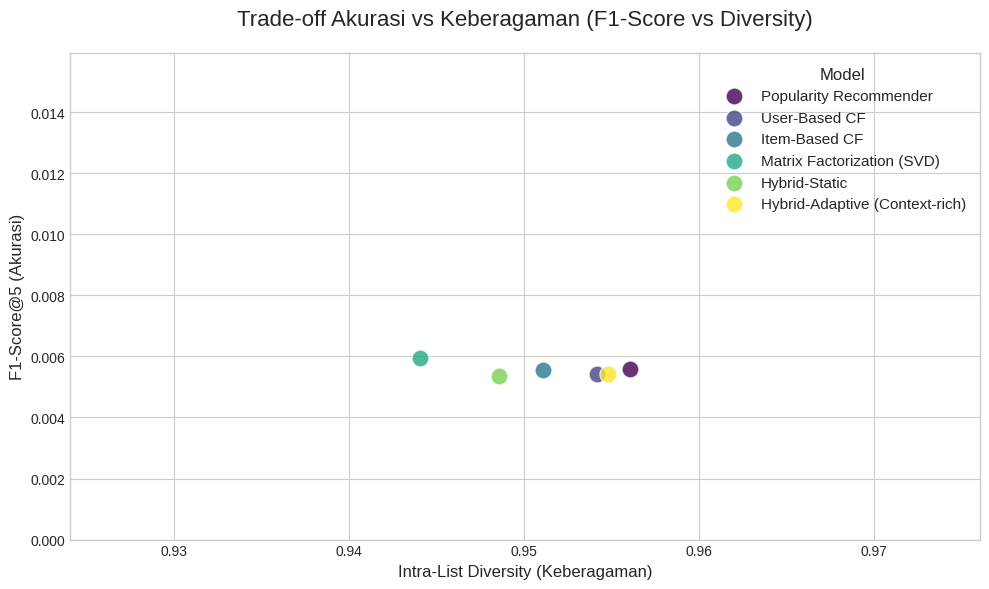

In [21]:
visualize_results(results_df)

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_diversity_novelty(results_df):
    """
    Visualisasi perbandingan model pada aspek Diversity dan Novelty.
    results_df: DataFrame hasil evaluasi, index=Model, kolom 'Intra-List Diversity', 'Novelty'
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot
    colors = plt.cm.plasma(np.linspace(0, 1, len(results_df)))
    for i, model_name in enumerate(results_df.index):
        ax.scatter(
            results_df['Intra-List Diversity'][i],
            results_df['Novelty'][i],
            s=150,
            color=colors[i],
            alpha=0.8,
            edgecolors='w',
            label=model_name
        )

    ax.set_title('Perbandingan Model: Diversity vs Novelty', fontsize=16, pad=20)
    ax.set_xlabel('Intra-List Diversity (Keberagaman)', fontsize=12)
    ax.set_ylabel('Novelty (Kebaruan)', fontsize=12)
    plt.xlim(left=max(0, results_df['Intra-List Diversity'].min() - 0.02),
             right=results_df['Intra-List Diversity'].max() + 0.02)
    plt.ylim(bottom=max(0, results_df['Novelty'].min() - 0.2),
             top=results_df['Novelty'].max() + 0.2)
    plt.legend(title="Model", fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()

<ipython-input-22-939120e33548>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Intra-List Diversity'][i],
<ipython-input-22-939120e33548>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Novelty'][i],


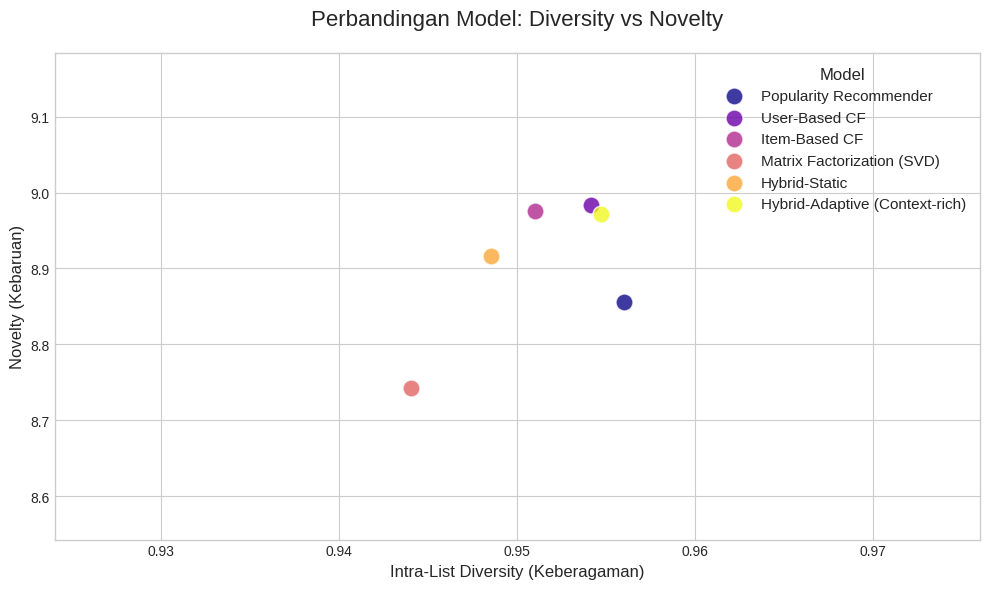

In [23]:
visualize_diversity_novelty(results_df)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bar_accuracy(results_df):
    """
    Barplot perbandingan Precision, Recall, F1-Score antar model.
    """
    results_df[['Precision@5', 'Recall@5', 'F1-Score@5']].plot.bar(figsize=(12,6))
    plt.title("Perbandingan Akurasi Model")
    plt.ylabel("Nilai")
    plt.xlabel("Model")
    plt.xticks(rotation=20)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def visualize_catalog_coverage(results_df):
    """
    Barplot Catalog Coverage per model.
    """
    results_df['Catalog Coverage'].plot.bar(figsize=(10,5), color='skyblue')
    plt.title("Catalog Coverage per Model")
    plt.ylabel("Catalog Coverage")
    plt.ylim(0,1)
    plt.xlabel("Model")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

def visualize_tradeoff_f1_coverage(results_df):
    """
    Scatterplot F1-Score vs Catalog Coverage.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8,6))
    colors = plt.cm.cividis(np.linspace(0, 1, len(results_df)))
    for i, model_name in enumerate(results_df.index):
        ax.scatter(
            results_df['Catalog Coverage'][i],
            results_df['F1-Score@5'][i],
            s=150,
            color=colors[i],
            alpha=0.9,
            edgecolors='w',
            label=model_name
        )
    ax.set_title('Trade-off Akurasi vs Catalog Coverage', fontsize=15)
    ax.set_xlabel('Catalog Coverage', fontsize=12)
    ax.set_ylabel('F1-Score@5', fontsize=12)
    plt.xlim(left=max(0, results_df['Catalog Coverage'].min() - 0.02), right=min(1, results_df['Catalog Coverage'].max() + 0.02))
    plt.ylim(bottom=max(0, results_df['F1-Score@5'].min() - 0.01), top=results_df['F1-Score@5'].max() + 0.01)
    plt.legend(title="Model", fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_diversity_novelty(results_df):
    """
    Scatterplot Intra-List Diversity vs Novelty.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.plasma(np.linspace(0, 1, len(results_df)))
    for i, model_name in enumerate(results_df.index):
        ax.scatter(
            results_df['Intra-List Diversity'][i],
            results_df['Novelty'][i],
            s=150,
            color=colors[i],
            alpha=0.8,
            edgecolors='w',
            label=model_name
        )
    ax.set_title('Perbandingan Model: Diversity vs Novelty', fontsize=16, pad=20)
    ax.set_xlabel('Intra-List Diversity (Keberagaman)', fontsize=12)
    ax.set_ylabel('Novelty (Kebaruan)', fontsize=12)
    plt.xlim(left=max(0, results_df['Intra-List Diversity'].min() - 0.02),
             right=results_df['Intra-List Diversity'].max() + 0.02)
    plt.ylim(bottom=max(0, results_df['Novelty'].min() - 0.2),
             top=results_df['Novelty'].max() + 0.2)
    plt.legend(title="Model", fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_tradeoff_f1_novelty(results_df):
    """
    Scatterplot F1-Score vs Novelty (Trade-off Akurasi vs Kebaruan)
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8,6))
    colors = plt.cm.magma(np.linspace(0, 1, len(results_df)))
    for i, model_name in enumerate(results_df.index):
        ax.scatter(
            results_df['F1-Score@5'][i],
            results_df['Novelty'][i],
            s=150,
            color=colors[i],
            alpha=0.9,
            edgecolors='w',
            label=model_name
        )
    ax.set_title('Trade-off F1-Score vs Novelty', fontsize=15)
    ax.set_xlabel('F1-Score@5', fontsize=12)
    ax.set_ylabel('Novelty', fontsize=12)
    plt.xlim(left=max(0, results_df['F1-Score@5'].min() - 0.01), right=results_df['F1-Score@5'].max() + 0.01)
    plt.ylim(bottom=max(0, results_df['Novelty'].min() - 0.2), top=results_df['Novelty'].max() + 0.2)
    plt.legend(title="Model", fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_popularity_histogram(all_rec_dict, train_df, model_names=None, bins=25):
    """
    Visualisasi histogram popularitas item yang direkomendasikan untuk tiap model.
    all_rec_dict: dict {model_name: list of all recommended item_ids}
    train_df: DataFrame dengan kolom 'item_id' untuk menghitung popularitas di data latih
    model_names: urutan nama model (opsional)
    """
    # Hitung popularitas (frequency) tiap item di train_df
    item_pop = train_df['item_id'].value_counts(normalize=True)
    plt.figure(figsize=(12, 6))
    model_names = model_names or list(all_rec_dict.keys())
    for model_name in model_names:
        item_list = all_rec_dict[model_name]
        # Ambil popularitas item rekomendasi
        pop_scores = [item_pop.get(item, 0) for item in item_list]
        plt.hist(pop_scores, bins=bins, alpha=0.5, label=model_name)
    plt.xlabel("Popularitas Item (Proporsi di Data Latih)")
    plt.ylabel("Jumlah Item Direkomendasikan")
    plt.title("Distribusi Popularitas Item yang Direkomendasikan")
    plt.legend()
    plt.tight_layout()
    plt.show()

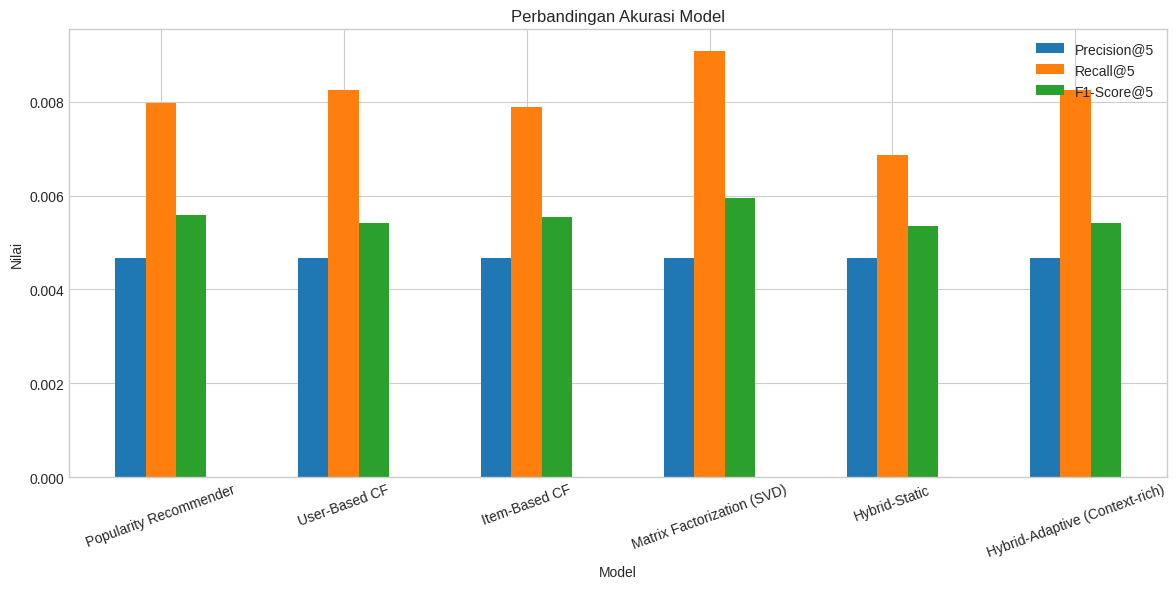

In [25]:
visualize_bar_accuracy(results_df)

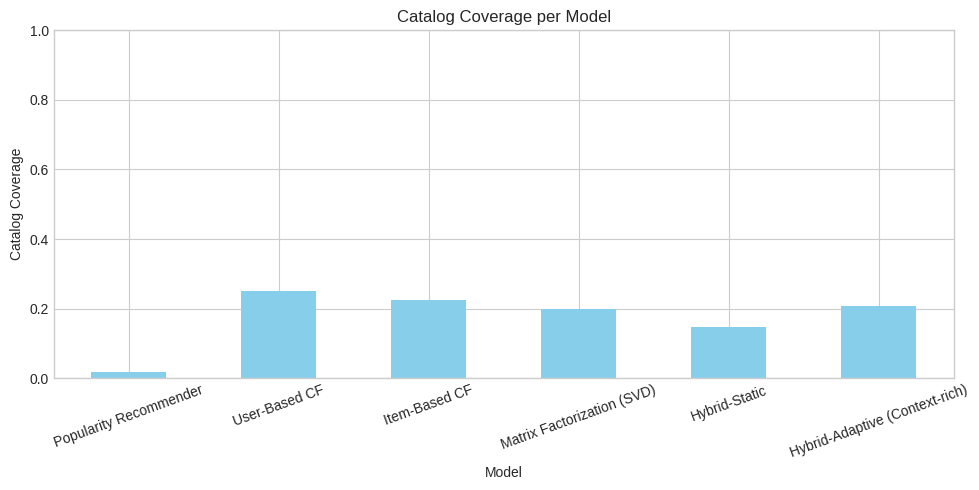

In [26]:
visualize_catalog_coverage(results_df)

<ipython-input-24-2e165b88ebe0>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Catalog Coverage'][i],
<ipython-input-24-2e165b88ebe0>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['F1-Score@5'][i],


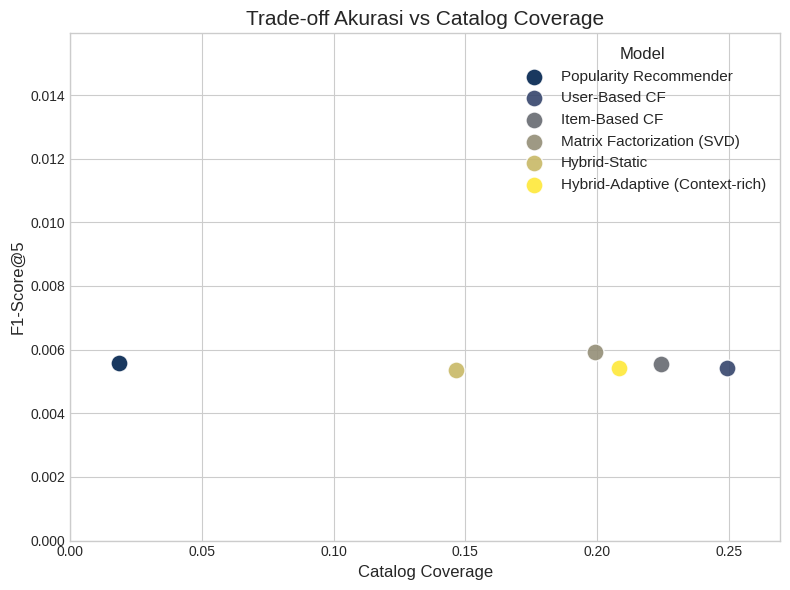

In [27]:
visualize_tradeoff_f1_coverage(results_df)

<ipython-input-24-2e165b88ebe0>:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Intra-List Diversity'][i],
<ipython-input-24-2e165b88ebe0>:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Novelty'][i],


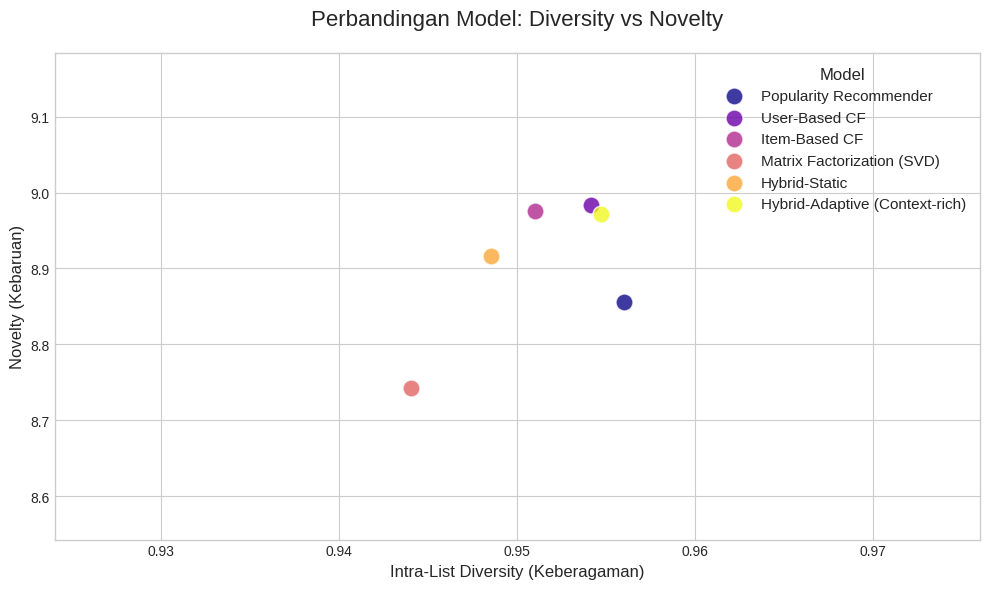

In [28]:
visualize_diversity_novelty(results_df)

<ipython-input-24-2e165b88ebe0>:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['F1-Score@5'][i],
<ipython-input-24-2e165b88ebe0>:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Novelty'][i],


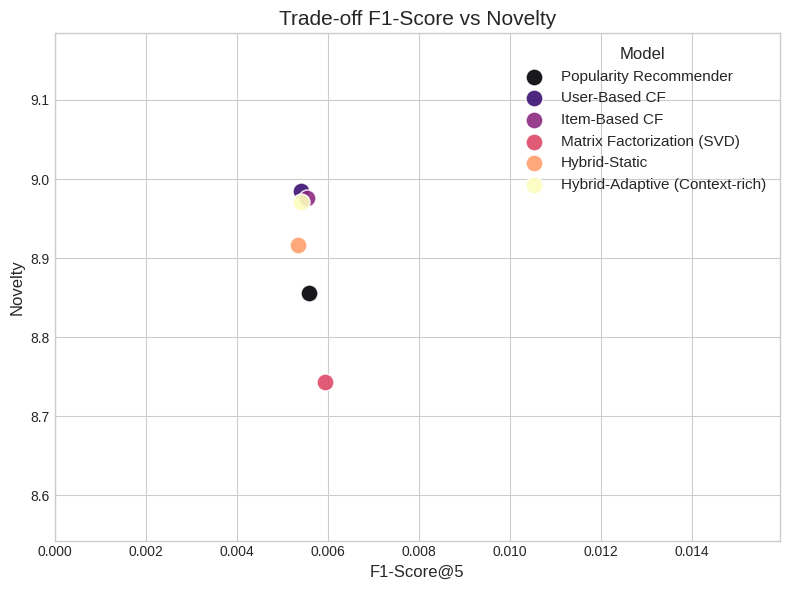

In [29]:
visualize_tradeoff_f1_novelty(results_df)

In [30]:
# Buat dictionary untuk menampung semua rekomendasi setiap model di seluruh user
all_rec_dict = {}

for model in models_to_evaluate:
    all_recs = []
    model.fit(evaluator.train_df)
    train_user_items = evaluator.train_df.groupby('user_id')['item_id'].apply(list).to_dict()
    for user_id in evaluator.test_users:
        items_to_ignore = train_user_items.get(user_id, [])
        # HybridAdaptive butuh similarity_matrix
        predict_kwargs = {'similarity_matrix': evaluator.similarity_matrix} if hasattr(model, 'mmr_lambda') else {}
        recs = model.predict(user_id, n=5, items_to_ignore=items_to_ignore, **predict_kwargs)
        all_recs.extend(recs)
    all_rec_dict[model.name] = all_recs

Fitting Hybrid-Adaptive (Context-rich)...


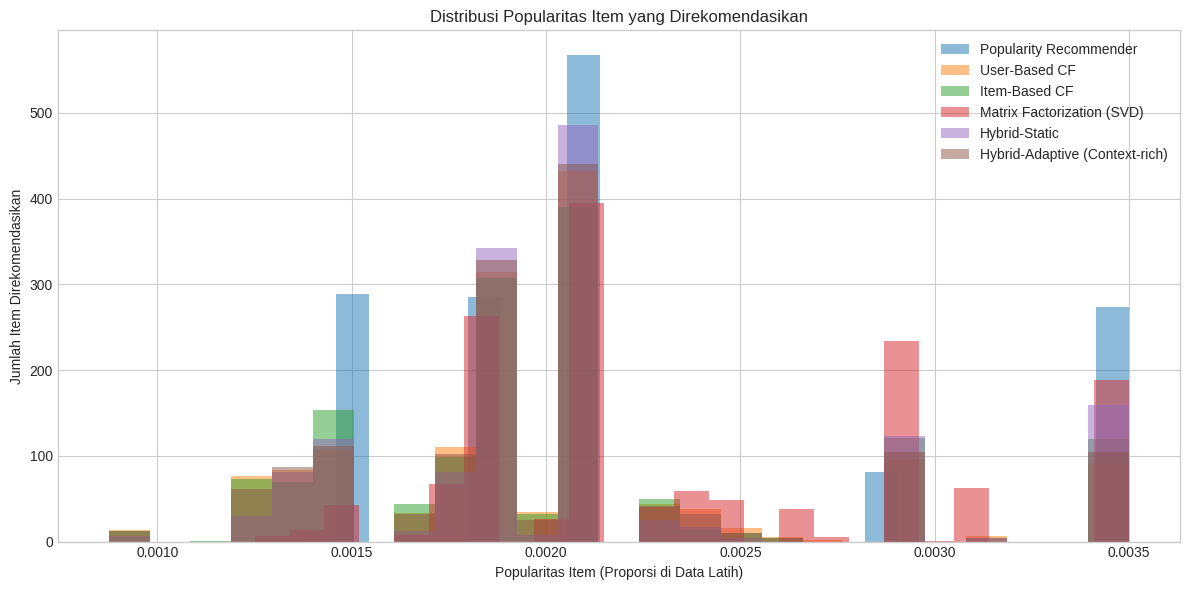

In [31]:
visualize_popularity_histogram(all_rec_dict, evaluator.train_df, model_names=[m.name for m in models_to_evaluate])